In [1]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
import shutil
from zipfile import ZipFile 

def zip_extractor(data):
    try:
        shutil.rmtree(data)
    except Exception:
        pass

    file_name = f"drive/My Drive/FER/datasets/{data}.zip"

    with ZipFile(file_name, 'r') as zip_:
        print('Extracting all the files...') 
        zip_.extractall(data)
        print('Done!')

In [29]:
DATA = "CK+48"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/DCNN/"

if "fer" in DATA:
    if DATA == "fer":
        zip_extractor(DATA)
        DATA_PATH = "fer/final/"
    else:
        zip_extractor(DATA)
        DATA_PATH = f"{DATA}/{DATA}/"
    TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]
    TRAIN_SIZE = 0.88
else:
    zip_extractor(DATA)
    DATA_PATH = f"{DATA}/{DATA}/"
    TOP_EMOTIONS = ["Happy", "Fear", "Sadness", "Surprise", "Anger"]
    TRAIN_SIZE = 0.75

INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

Extracting all the files...
Done!


In [15]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Anger has 135 number of images
Surprise has 249 number of images
Happy has 207 number of images
Sadness has 84 number of images
Fear has 75 number of images

total images are 750


In [16]:
for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

750

In [17]:
img_arr = np.empty(shape=(total_images, *INPUT_SHAPE))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):

    if dir_ in TOP_EMOTIONS:
        label_to_text[label] = dir_
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1

        print(f"loaded {dir_} images to numpy arrays...")
        label += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label.shape

loaded Anger images to numpy arrays...
loaded Fear images to numpy arrays...
loaded Happy images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Surprise images to numpy arrays...


((750, 48, 48, 1), (750, 5))

In [18]:
label_to_text

{0: 'Anger', 1: 'Fear', 2: 'Happy', 3: 'Sadness', 4: 'Surprise'}

In [19]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Anger': 0, 'Fear': 1, 'Happy': 2, 'Sadness': 3, 'Surprise': 4}

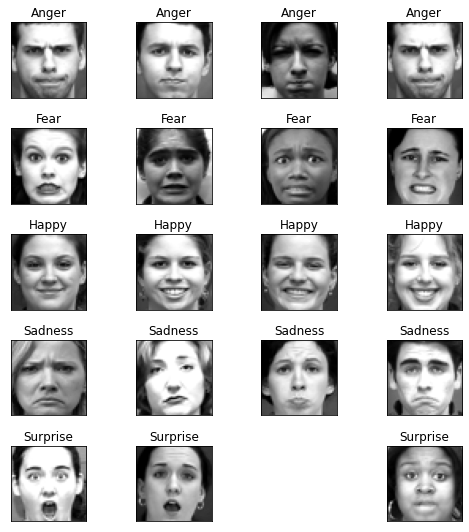

In [21]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
img_arr = img_arr / 255.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.7, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((525, 48, 48, 1), (225, 48, 48, 1), (525, 5), (225, 5))

In [0]:
def build_cnn(input_shape, num_classes, show_summary=True):
    model_in = Input(shape=input_shape, name="input_CNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.5, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
        
    dense_1 = Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.6, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation="softmax",
        name="ouput_CNN"
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out)
    
    if show_summary:
        model.summary()
    
    return model

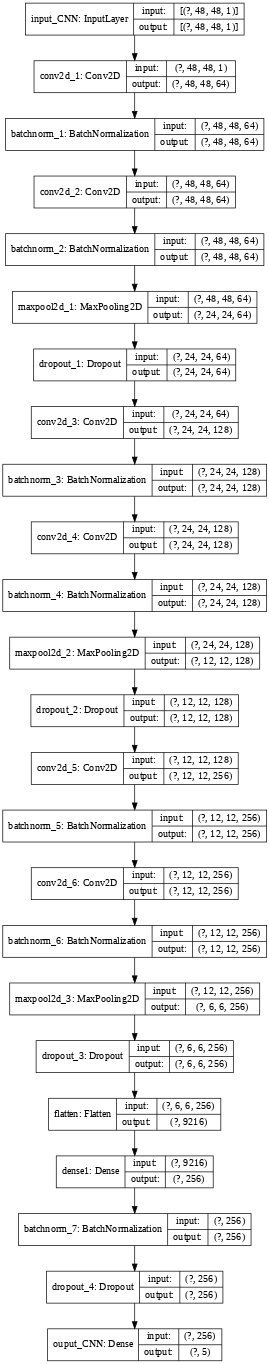

In [98]:
model = build_cnn(INPUT_SHAPE, NUM_CLASSES, show_summary=False)
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50,)# to_file=BASE_PATH+'architecture/deep_cnn.png')

In [0]:
train_datagen_1 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_datagen_2 = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.08,
    horizontal_flip=True,
)

In [0]:
early_stopping_1 = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

early_stopping_2 = EarlyStopping(
    monitor='accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
lr_scheduler_1 = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

lr_scheduler_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

In [0]:
if "fer" in DATA:
    BEST_CONFIG = {
        "batch_size": 20,
        "epochs": 65,
        "loss": "categorical_crossentropy",
        "optim": optimizers.Adam(0.01),
        "train_datagen": train_datagen_1,
        "lr_scheduler": lr_scheduler_1,
        "callbacks": [lr_scheduler_1],
    }
else:
    BEST_CONFIG = {
        "batch_size": 12,
        "epochs": 100,
        "loss": "categorical_crossentropy",
        "optim": optimizers.Adam(0.01),
        "train_datagen": train_datagen_1,
        "lr_scheduler": lr_scheduler_2,
        "callbacks": [lr_scheduler_2, early_stopping_2],
    }

In [103]:
model.compile(
        loss=BEST_CONFIG["loss"],
        optimizer=BEST_CONFIG["optim"],
        metrics=['accuracy']
)

BEST_CONFIG["train_datagen"].fit(X_train)
history = model.fit(
    BEST_CONFIG["train_datagen"].flow(X_train, y_train, batch_size=BEST_CONFIG["batch_size"]),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / BEST_CONFIG["batch_size"],
    epochs=BEST_CONFIG["epochs"],
    callbacks=BEST_CONFIG["callbacks"],
)

Epoch 1/100
44/43 [==============================] - 1s 15ms/step - loss: 2.3570 - accuracy: 0.3543 - val_loss: 84.5870 - val_accuracy: 0.1822 - lr: 0.0100
Epoch 2/100
44/43 [==============================] - 0s 11ms/step - loss: 1.7672 - accuracy: 0.4343 - val_loss: 14.0544 - val_accuracy: 0.4222 - lr: 0.0100
Epoch 3/100
44/43 [==============================] - 1s 12ms/step - loss: 1.3265 - accuracy: 0.5543 - val_loss: 3.7141 - val_accuracy: 0.4133 - lr: 0.0100
Epoch 4/100
44/43 [==============================] - 1s 11ms/step - loss: 1.1304 - accuracy: 0.6190 - val_loss: 1.3180 - val_accuracy: 0.6933 - lr: 0.0100
Epoch 5/100
44/43 [==============================] - 0s 11ms/step - loss: 1.0809 - accuracy: 0.6495 - val_loss: 2.1947 - val_accuracy: 0.5378 - lr: 0.0100
Epoch 6/100
44/43 [==============================] - 1s 11ms/step - loss: 0.8451 - accuracy: 0.6857 - val_loss: 1.1047 - val_accuracy: 0.7111 - lr: 0.0100
Epoch 7/100
44/43 [==============================] - 0s 11ms/step - 

In [0]:
model.save(BASE_PATH+f"dumps/cnn_{DATA}_{NUM_CLASSES}emo.h5")

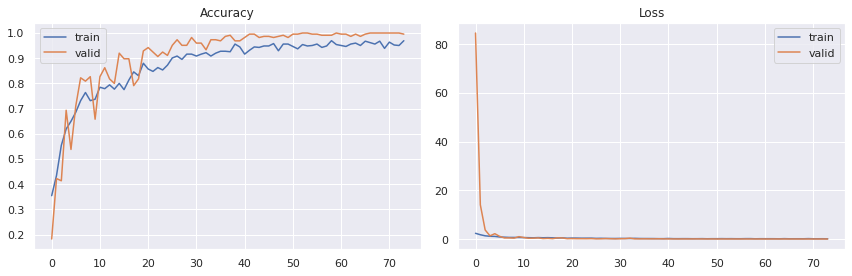

In [107]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(BASE_PATH+f'epoch_metrics/cnn_{DATA}_{NUM_CLASSES}emo.png')
pyplot.show()

In [108]:
label_to_text

{0: 'Anger', 1: 'Fear', 2: 'Happy', 3: 'Sadness', 4: 'Surprise'}

test accuracy: 99.1111 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.92      1.00      0.96        23
           2       1.00      1.00      1.00        62
           3       1.00      1.00      1.00        25
           4       1.00      0.97      0.99        75

    accuracy                           0.99       225
   macro avg       0.98      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



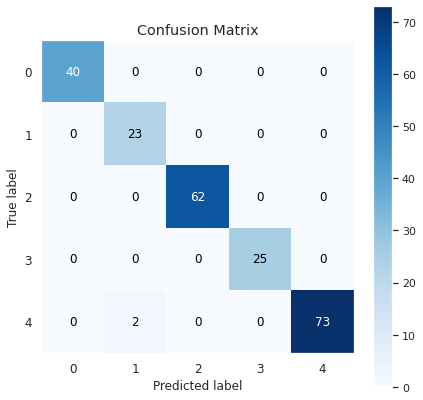

In [110]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(BASE_PATH+f"confusion_matrix/cnn_{DATA}_{NUM_CLASSES}emo.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [111]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 100.0 %


### Visualizing the Model

In [112]:
X_test[0].shape

(48, 48, 1)

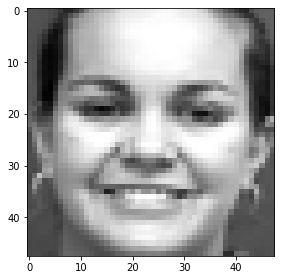

In [113]:
sns.reset_orig()

img = X_test[0]
ax = pyplot.subplot(1,1,1)
ax.imshow(img.reshape(48,48), cmap="gray")
pyplot.tight_layout()

In [114]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 48, 48, 1)

In [115]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa825f13b70>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa825f21048>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa86a3b2710>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa8663dfa58>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa825fbf2b0>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa8de643390>)]

In [0]:
INTERESTED_LAYERS = [f"conv2d_{i}" for i in range(1,7)]

#### Let's visualize feature maps

CPU times: user 54.5 s, sys: 677 ms, total: 55.2 s
Wall time: 54.4 s


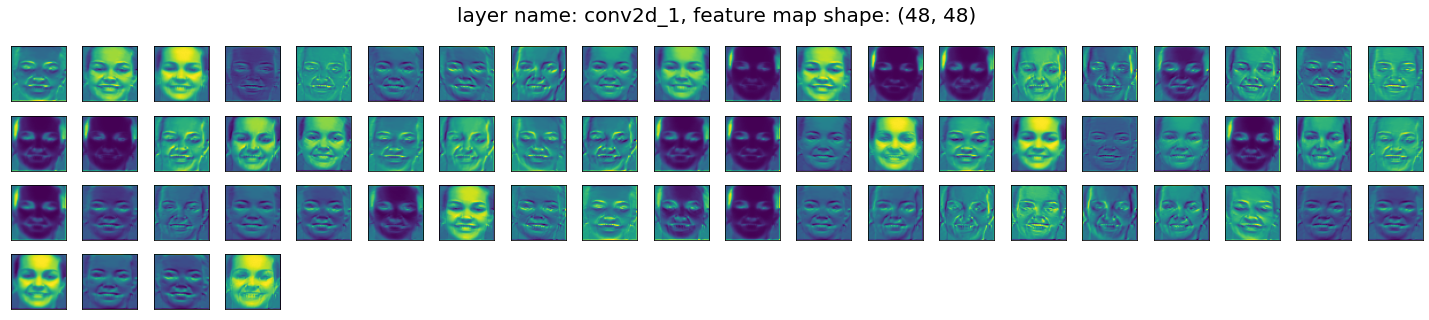

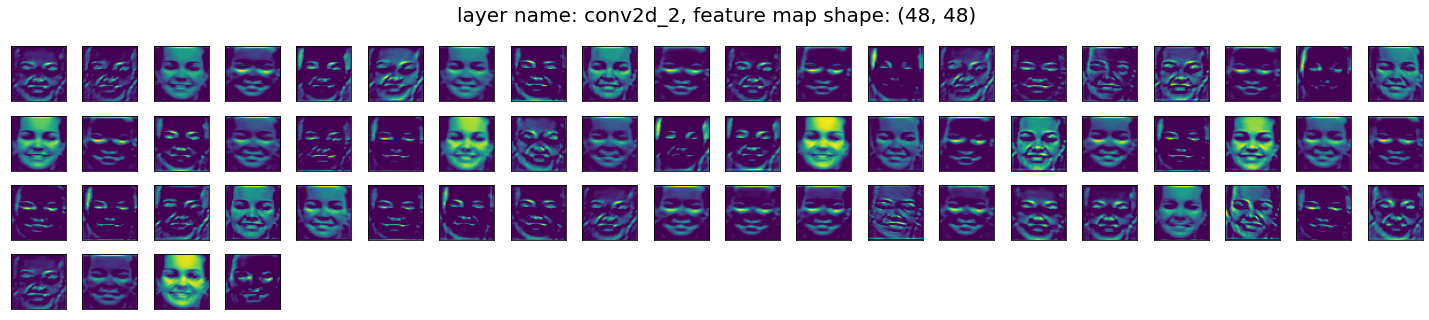

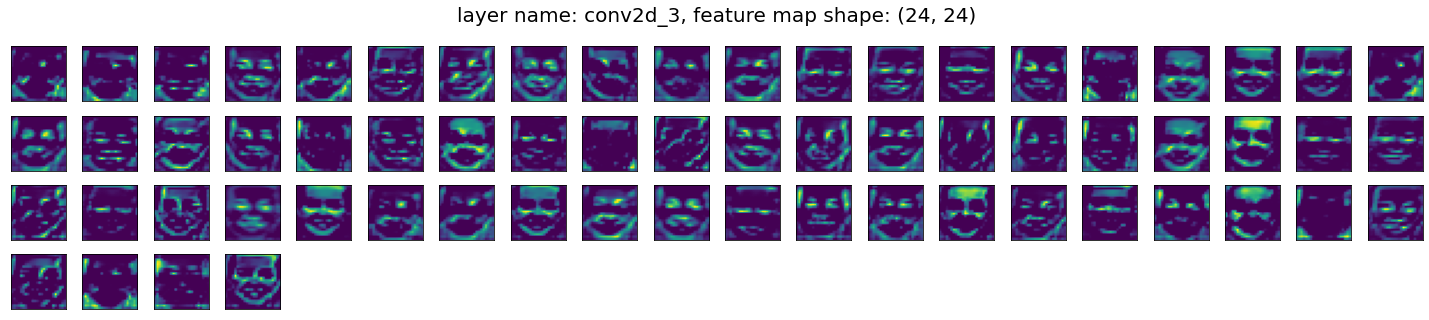

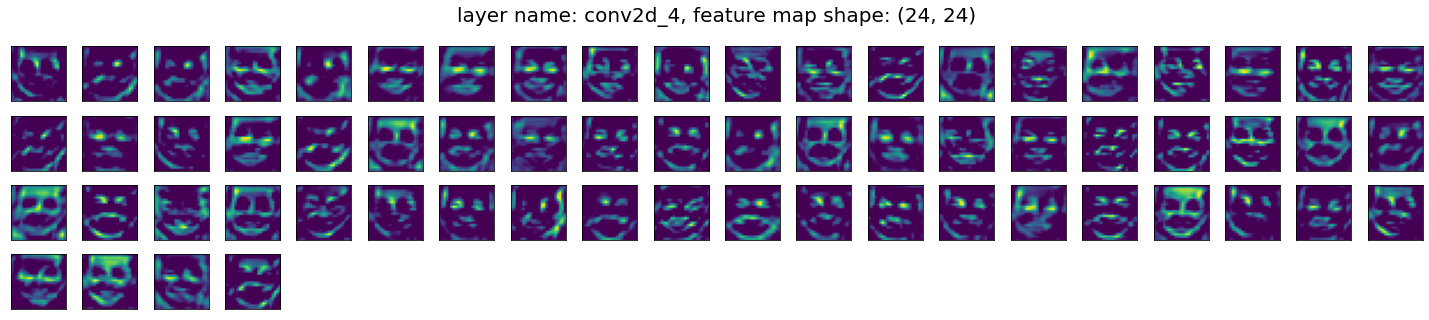

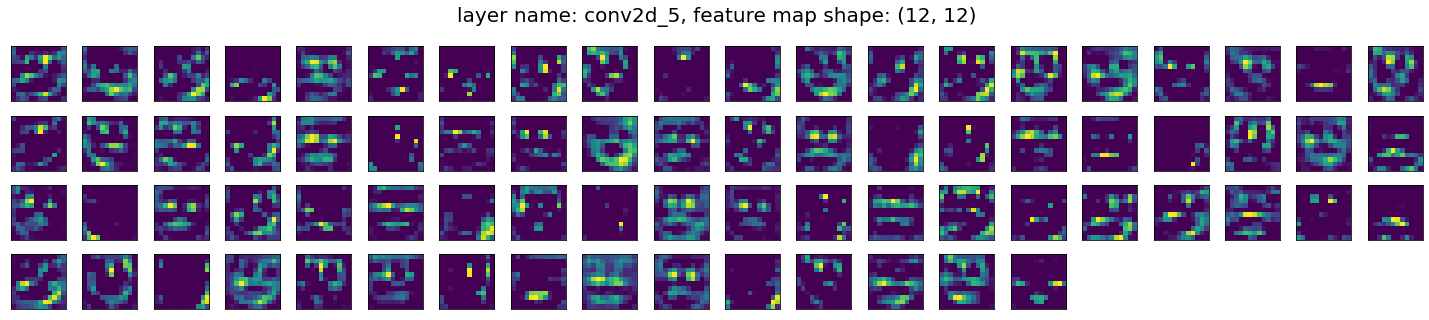

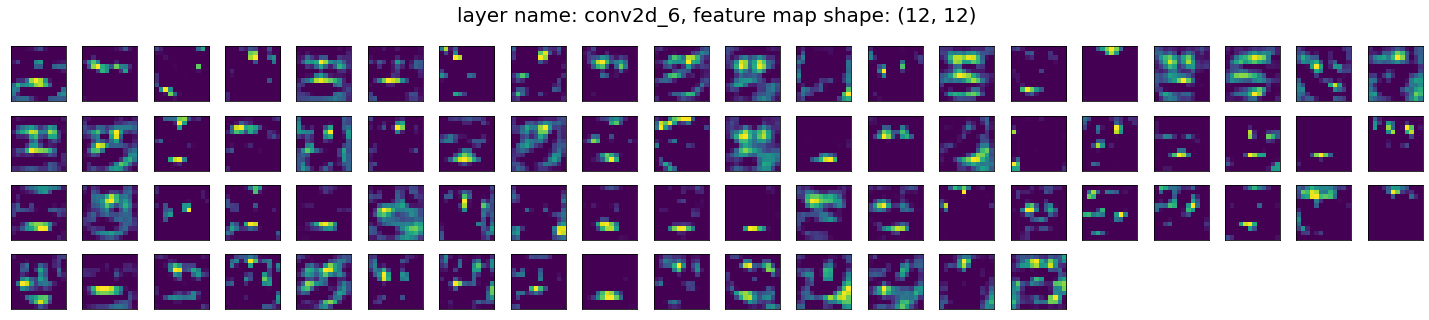

In [119]:
%%time

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_LAYERS:
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(img)
        num_featuremaps = featuremaps_conv2d.shape[3]

        if num_featuremaps <= 64:
            pass
        elif num_featuremaps <= 128:
            sample_fm = np.random.choice(range(num_featuremaps), size=64, replace=False)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,sample_fm]
        else:
            sample_fm = np.random.choice(range(num_featuremaps), size=75, replace=False)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,sample_fm]
        
        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (cols, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape[1:3]}", fontsize=20, y=1.1)
            pyplot.tight_layout()

#### Let's plot Class Activation Map (CAM)

In [120]:
preds = model.predict(img)
label_to_text[np.argmax(preds[0])]

'Happy'

In [121]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>

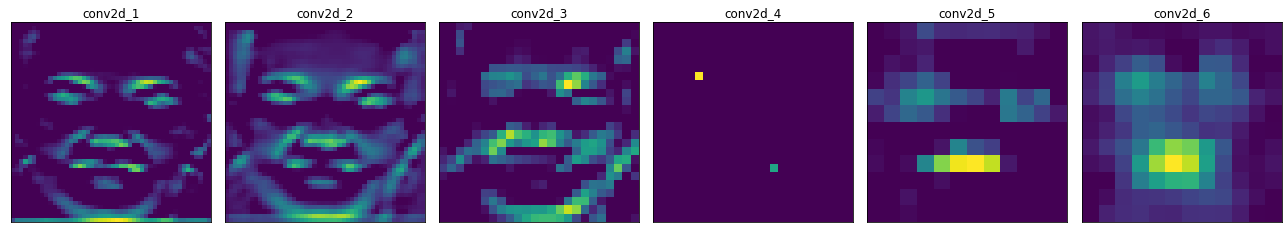

In [122]:
heatmaps = []
for layer in layer_list:
    if layer[0] in INTERESTED_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([img])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(18, 4))

for i, (name,hm) in enumerate(zip(INTERESTED_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, len(INTERESTED_LAYERS), i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

pyplot.show()

#### Let's see some results

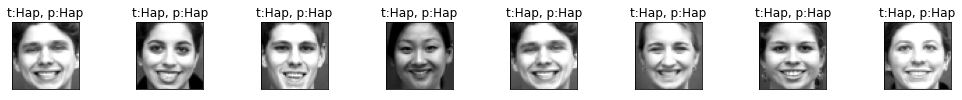

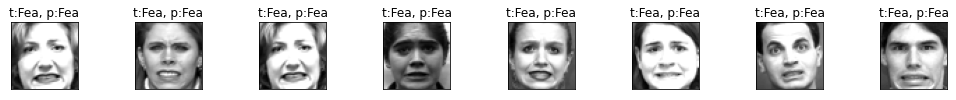

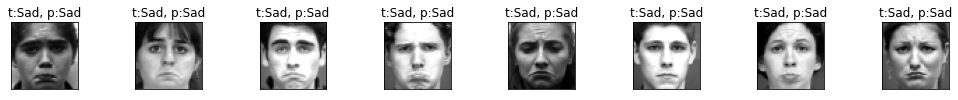

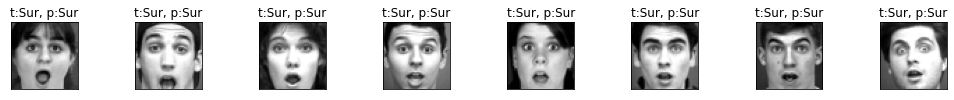

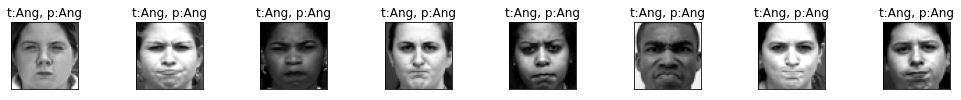

In [130]:
f = 1
for emotion in TOP_EMOTIONS:
    emotion_imgs = np.random.choice(np.where(y_test[:, text_to_label[emotion]]==1)[0], size=8, replace=False)

    pyplot.figure(f, (16,1.5))
    f += 1

    for i,img_idx in enumerate(emotion_imgs):
        sample_img = X_test[img_idx,:,:,0]
        pred = label_to_text[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
        ax = pyplot.subplot(1, 9, i+1)
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{emotion[:3]}, p:{pred[:3]}")
        pyplot.tight_layout()

#### Let's visualize the mistakes made by our model

In [0]:
def plot_miss_classified(emotion,fig):
    miss_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]

    if len(miss_indices) > 0:
        cols = 15
        rows = math.ceil(len(miss_indices) / cols)
        pyplot.figure(fig, (20, rows*1.5))

        for i,idx in enumerate(miss_indices):
            sample_img = X_test[idx,:,:,0]
            pred = label_to_text[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
            ax = pyplot.subplot(rows,cols,i+1)
            ax.imshow(sample_img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"p:{pred}")
            pyplot.suptitle(f"total {len(miss_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}", y=1, fontsize=16)

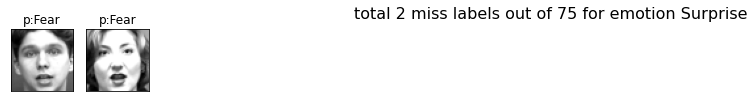

In [140]:
for fig,emotion in enumerate(TOP_EMOTIONS):
    plot_miss_classified(emotion, fig)